### Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Tuple, Callable, Optional, TypedDict

### Main part

##### Task 1

Calculations needed for task 1 and 9 can be found at the end of pdf with report written out by hand.

##### Task 2

In [2]:
def gibbs_sampler(num_samples: int, previous: Tuple[int, int] = (0, 0), thin_out: int = 1, burn_in: int = 0) -> pd.DataFrame:
    ret = [previous]  # Since these are Markov chains we only need to remember the last generated item
    for t in range(burn_in + num_samples * thin_out):
        idx = int(np.random.rand() > .5)
        cloud_prob = 4./9. if previous[0] else 1./21.
        rain_prob = .815 if previous[1] else .216
        previous = (np.random.choice((0, 1), p=[1 - rain_prob, rain_prob]), previous[1]) if idx == 0 else (previous[0], np.random.choice((0, 1), p=[1 - cloud_prob, cloud_prob]))
        if t > burn_in:
            if (t - burn_in) % thin_out == 0:
                ret.append(previous)

    return pd.DataFrame(ret, columns=["Rain", "Cloudy"])


In [3]:
N = 100
gibbs_sampler(N)

,Rain,Cloudy
0,0,0
1,0,0
2,0,0
3,0,1
4,1,1
...,...,...
95,1,1
96,1,0
97,0,0
98,0,0


##### Task 3

In [4]:
probs = gibbs_sampler(N).mean()
print(f"P(R = T | S = T, W = T) is approximately: {probs['Rain']}")

P(R = T | S = T, W = T) is approximately: 0.21


##### Task 4 & 5

P(R = T | S = T, W = T) approximated by sampling 50 000 samples: 0.32046


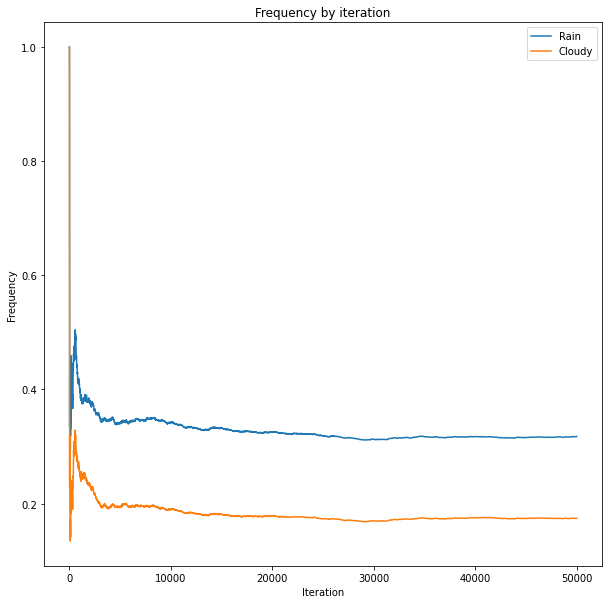

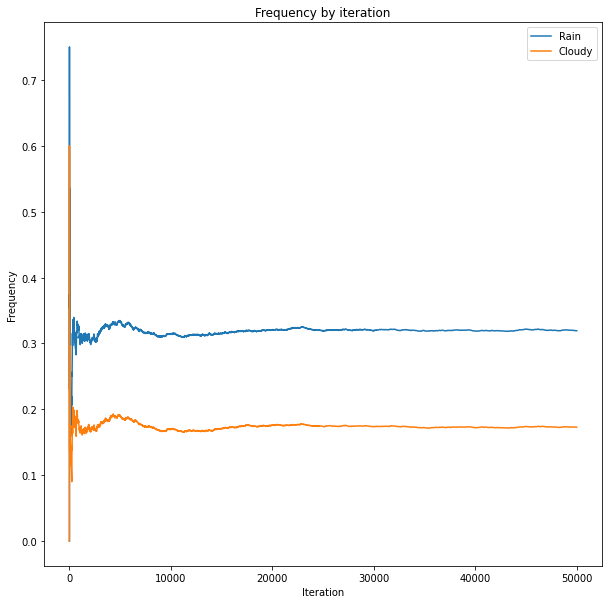

In [5]:
def freq_by_iter(num_iter: int, **kwargs ) -> pd.DataFrame:
    gibbs = gibbs_sampler(num_iter, **kwargs)
    return gibbs.cumsum().divide(gibbs["Rain"].index.values, axis=0)

N = 50000
print(f"P(R = T | S = T, W = T) approximated by sampling 50 000 samples: {gibbs_sampler(N).mean()['Rain']}")
for _ in range(2):
    freq_by_iter(N).plot(title="Frequency by iteration", ylabel="Frequency", xlabel="Iteration", figsize=(10, 10))
    plt.show()



Based on the plot above I would suggest burn-in time of at least 7500 iterations. However, if we want to be sure the burn-in time is sufficient 10000 iterations may be better idea.

##### Task 6

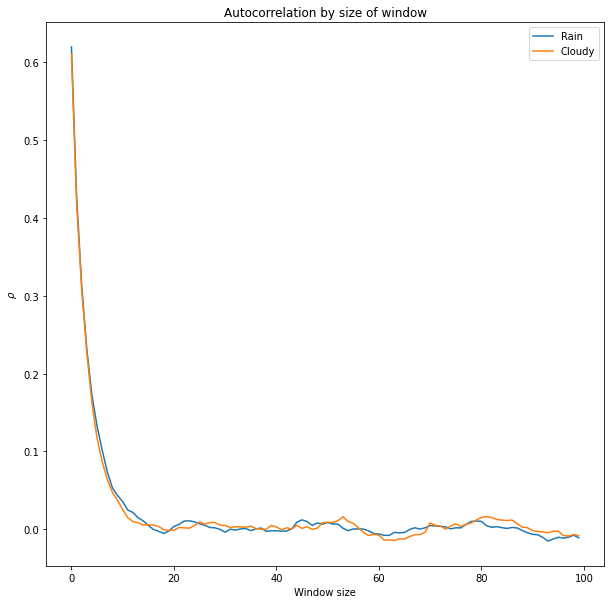

In [6]:
def autocorr_plot(samples: pd.DataFrame, max_lag: int = 100):
    autocorrs = [(samples["Rain"].autocorr(i), samples["Cloudy"].autocorr(i)) for i in range(1, max_lag + 1)]

    plt.figure(figsize=(10, 10))
    plt.plot(autocorrs, label=["Rain", "Cloudy"])
    plt.title("Autocorrelation by size of window")
    plt.xlabel("Window size")
    plt.ylabel("$\\rho$")
    plt.legend()
    plt.show()

autocorr_plot(gibbs_sampler(N), 100)

Based on this plot I would suggest interval of 20 iterations for drawing approximately independent samples.



##### Task 7
See implementaion of `gibbs_sampler` above (`Task 2`).

##### Task 8

In [7]:
print(f"P(R = T | S = T, W = T) approximated with burn-in and thinning-out: {gibbs_sampler(100, burn_in=10000, thin_out=20).mean()['Rain']}, \napproximation in Task 3 was: {probs['Rain']}")

P(R = T | S = T, W = T) approximated with burn-in and thinning-out: 0.37, 
approximation in Task 3 was: 0.21


Due to small number of samples both approximations are quite random, however approximation with burn-in and thinning-out is more likely to be close to the real value of this probability which is `0.32`. See histograms below:

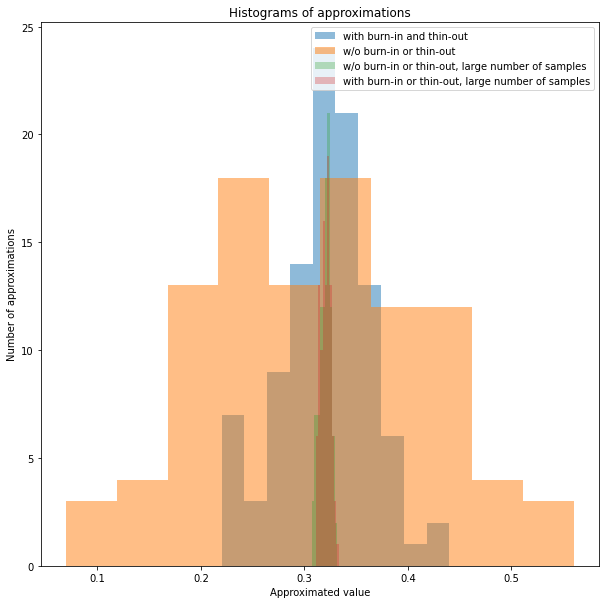

In [8]:
vanila = []
burn_thin = []
large = []
large_burn = []
for _ in range(100):
    vanila.append(gibbs_sampler(100).mean()["Rain"])
    burn_thin.append(gibbs_sampler(100, burn_in=10000, thin_out=20).mean()["Rain"])
    large.append(gibbs_sampler(50000).mean()["Rain"])
    large_burn.append(gibbs_sampler(50000).mean()["Rain"])

plt.figure(figsize=(10, 10))
plt.hist(burn_thin, label="with burn-in and thin-out", alpha=.5)
plt.hist(vanila, label="w/o burn-in or thin-out", alpha=.5)
plt.hist(large, label='w/o burn-in or thin-out, large number of samples', alpha=.3)
plt.hist(large_burn, label='with burn-in or thin-out, large number of samples', alpha=.3)
plt.ylabel("Number of approximations")
plt.xlabel("Approximated value")
plt.title("Histograms of approximations")
plt.legend()
plt.show()

In those we can see that approximation by sampling with burn-in and thin-out is concentrated around real value `0.32` while the one without burn-in and thin-out is much more diverse.
As we can see taking larger number of samples gives better approximation even without burn-in or thinning out (and even better with them).

##### Task 10 - Convergence diagnostics

In [9]:
def gelman_rubin_samples(samples: np.array) -> np.array:
    """
    Calculates Gelman-Rubin statistic for chain from which came samples.
    :param samples: array of shape (m, n, k) where m - number of chains, n- number of samples, k- number of batched chains in sample (i.e. 2 when we work with sampler from SAD project)
    :return: array of length k containing Gelman-Rubin statistics for each of batched chains.
    """
    m, n, k = samples.shape
    W = np.empty(k)
    B = np.empty(k)
    sigma_hat = np.empty(k)
    for i in range(k):
        sample = samples[:, :, i]
        W[i] = np.var(sample, axis=1).mean()
        B[i] = np.var(sample.mean(axis=1))
        sigma_hat[i] = (n-1)/n * W[i] + B[i]
    V_hat = sigma_hat + B/(n * m)
    return np.sqrt(V_hat/W)




def gelman_rubin(sampler: Callable[[int, Optional[Tuple[int, int]], Optional[int], Optional[int]], pd.DataFrame], num_iter: int, num_samples: int = 3, **kwargs: TypedDict) -> float:
    samples = np.stack([sampler(num_iter, **kwargs).to_numpy() for _ in range(num_samples)])
    return gelman_rubin_samples(samples)



In [10]:

def gelman_plot(samples: np.array):
    """
    Generates plot of Gelman-Rubin statistic. Function needs chains of length greater than 50.
    :param samples: Samples from m markov chains
    """
    assert samples.shape[1] > 50, "More than 50 samples needed from each chain"
    ret = []
    for i in tqdm(range(40, samples.shape[1])):
        ret.append(gelman_rubin_samples(samples[:, :i, :]))

    plt.figure(figsize=(10, 10))
    plt.plot(ret, label=["Rain", "Cloudy"])
    plt.ylabel("Shrink factor")
    plt.xlabel("Iteration")
    plt.title("Gelman-rubin statistic")
    plt.legend()
    plt.ylim(bottom=1., top=1.01)
    plt.show()


100%|██████████| 9960/9960 [00:04<00:00, 2246.47it/s]


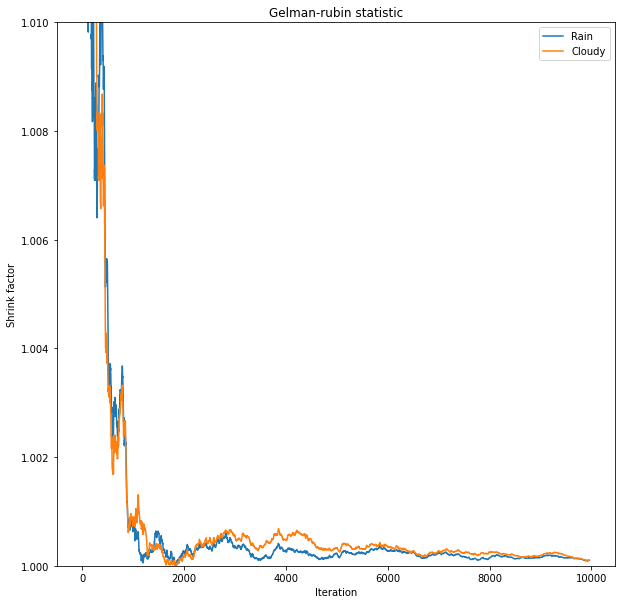

In [11]:
samples = 10000
sample = np.stack([gibbs_sampler(samples, previous=(1, 1)).to_numpy() for _ in range(7)])

gelman_plot(sample)

In this plot we can see that with number of iterations going up value of statistic is converging to 1, so we can assume that the chains are convergent.